# EMWA & HW

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('prepdata.xlsx',index_col=0,parse_dates=True)
df.dropna(axis='columns',inplace=True)
df.head()

,CO1 Comdty,CO2 Comdty,CO3 Comdty,CO4 Comdty,PVMMDS12 Index,PVMMDS23 Index,PVMMD2M3 Index,PVMMD3M4 Index,PVMMDBSP Index,DKI1 Comdty,...,CFCDQORS Index,CFCDPORL Index,CFCDPORS Index,CFCDQPTS Index,CFCDQSWD Index,CFCDPMMD Index,OISTCRDE Index,GBPUSD Curncy,EURUSD Curncy,JPYUSD Curncy
2018-01-02,66.57,66.13,65.79,65.51,0.25,0.25,0.25,0.25,3.08,64.01,...,55237,36753,39940,70,388157,47687,2480,1.3590,1.2059,0.008906
2018-01-03,67.84,67.29,66.90,66.57,0.26,0.26,0.26,0.26,3.36,65.24,...,55237,36753,39940,70,388157,47687,2526,1.3516,1.2015,0.008888
2018-01-04,68.07,67.51,67.11,66.77,0.29,0.29,0.29,0.29,3.34,65.30,...,55237,36753,39940,70,388157,47687,2539,1.3551,1.2068,0.008869
2018-01-05,67.62,67.10,66.73,66.41,0.28,0.26,0.28,0.26,3.29,64.93,...,55237,36753,39940,70,388157,47687,2539,1.3571,1.2029,0.008844
2018-01-08,67.78,67.31,66.95,66.64,0.26,0.24,0.26,0.24,3.24,65.09,...,55237,36753,39940,70,388157,47687,2538,1.3568,1.1967,0.008842


In [3]:
price_index = 'PVMPGDM4 Index'

In [4]:
df1 = df[[price_index]]
df1.index.freq = 'B'

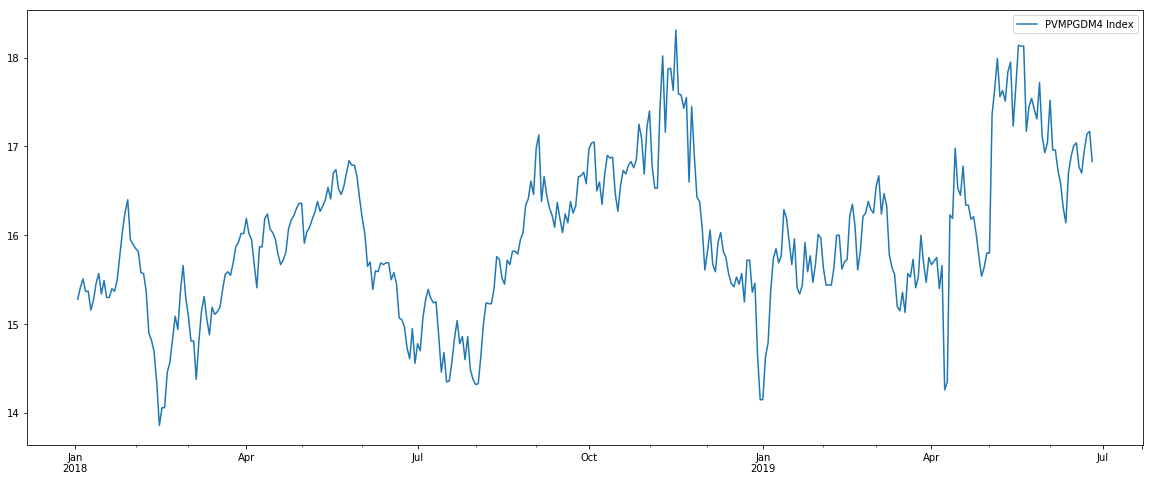

In [5]:
df1.plot(figsize=(20,8),legend=True);

## ETS Decomposition

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

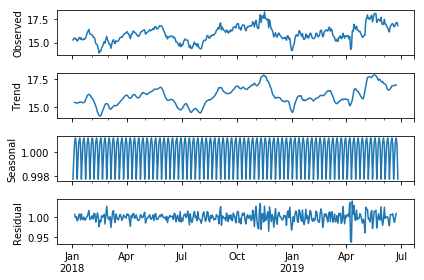

In [7]:
seasonal_decompose(df1[price_index],model='mul').plot();

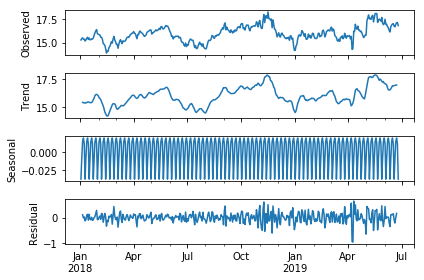

In [8]:
seasonal_decompose(df1[price_index],model='add').plot();

## Moving Average
### SMA
#### Simple Moving Average

In [9]:
df1['SMA_5'] = df1[price_index].rolling(window=5).mean()
df1['SMA_10'] = df1[price_index].rolling(window=10).mean()

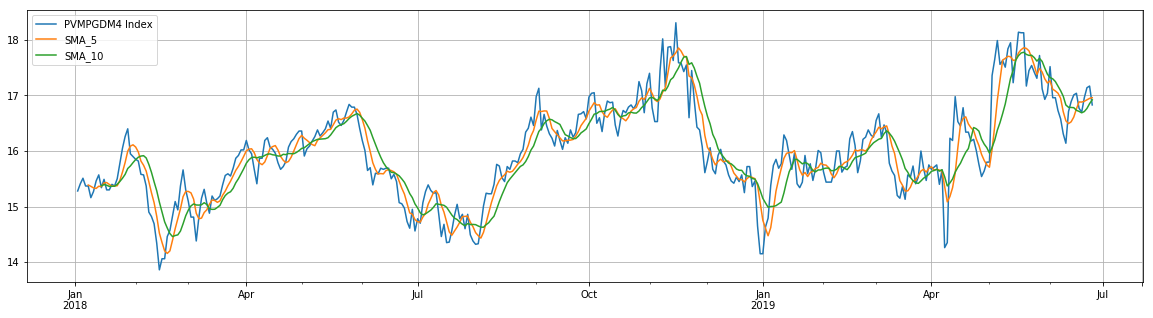

In [10]:
df1.plot(figsize=(20,5),grid=True);

SMA_10 is better at showing trend while SMA_5 have include some spike

### EWMA
#### Exponential Weighted Moving Average

In [11]:
df1['EMW_10'] = df1[price_index].ewm(span=10,adjust=False).mean()

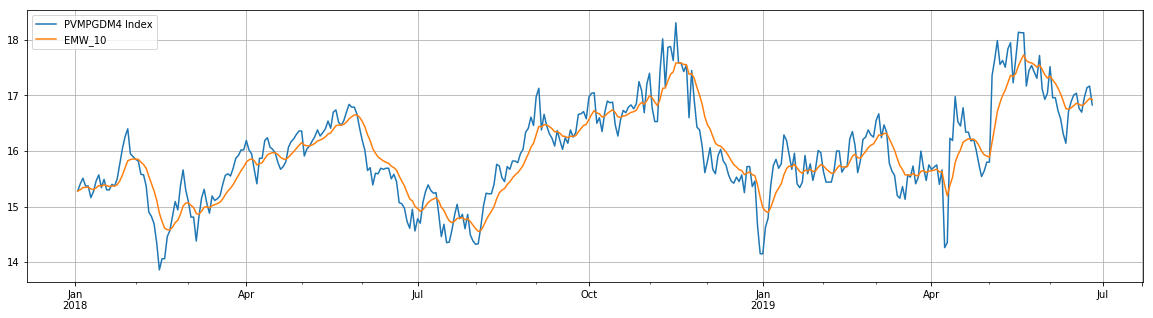

In [12]:
df1[[price_index,'EMW_10']].plot(figsize=(20,5),grid=True);

### Compare SMA to EWMA

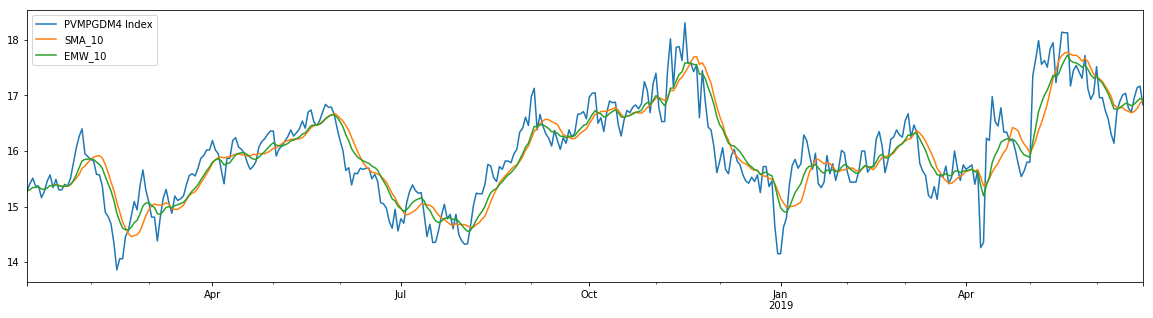

In [13]:
df1[[price_index,'SMA_10','EMW_10']].plot(figsize=(20,5)).autoscale(axis='x',tight=True)

## Holt-Winters Methods
### SES
#### Simple Exponential Smoothing

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [15]:
span = 10
alpha = 2/(span+1)
model = SimpleExpSmoothing(df1[price_index])
fitted_model = model.fit(smoothing_level=alpha,optimized=False)
df1['SES10'] = fitted_model.fittedvalues.shift(-1)
# df['SES10']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

<div class="alert alert-danger"><strong>NOTE:</strong> For some reason, when <tt>optimized=False</tt> is passed into <tt>.fit()</tt>, the statsmodels <tt>SimpleExpSmoothing</tt> function shifts fitted values down one row. We fix this by adding <tt>.shift(-1)</tt> after <tt>.fittedvalues</tt></div>

In [16]:
df1.head()

,PVMPGDM4 Index,SMA_5,SMA_10,EMW_10,SES10
2018-01-02,15.28,NaN,NaN,15.280000,15.280000
2018-01-03,15.41,NaN,NaN,15.303636,15.303636
2018-01-04,15.51,NaN,NaN,15.341157,15.341157
2018-01-05,15.37,NaN,NaN,15.346401,15.346401
2018-01-08,15.37,15.388,NaN,15.350692,15.350692


### DES
#### Double Exponential Smoothing

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [18]:
df1['DES_add10'] = ExponentialSmoothing(df1[price_index].astype(np.float),trend='add',seasonal_periods=10).fit().fittedvalues.shift(-1)
df1['DES_mul10'] = ExponentialSmoothing(df1[price_index].astype(np.float),trend='mul',seasonal_periods=10).fit().fittedvalues.shift(-1)

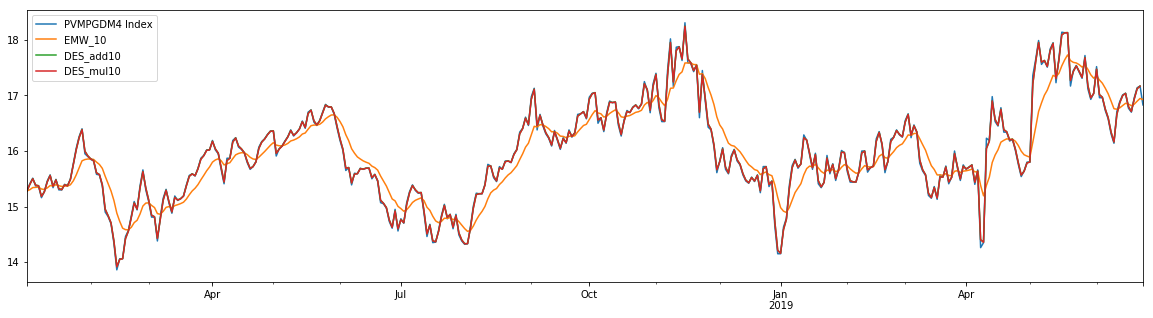

In [19]:
df1[[price_index,'EMW_10','DES_add10','DES_mul10']].plot(figsize=(20,5)).autoscale(axis='x',tight=True)

DES_add10 and DES_mul10 show excellent performance, however we need to evaluate the model later to determine which one is the best.

### TES
#### Triple Exponential Smoothing

In [26]:
df1['TES_add10'] = ExponentialSmoothing(df1[price_index].astype(np.float),trend='add',seasonal='add',seasonal_periods=10).fit().fittedvalues.shift(-1)
df1['TES_mul10'] = ExponentialSmoothing(df1[price_index].astype(np.float),trend='mul',seasonal='mul',seasonal_periods=10).fit().fittedvalues.shift(-1)

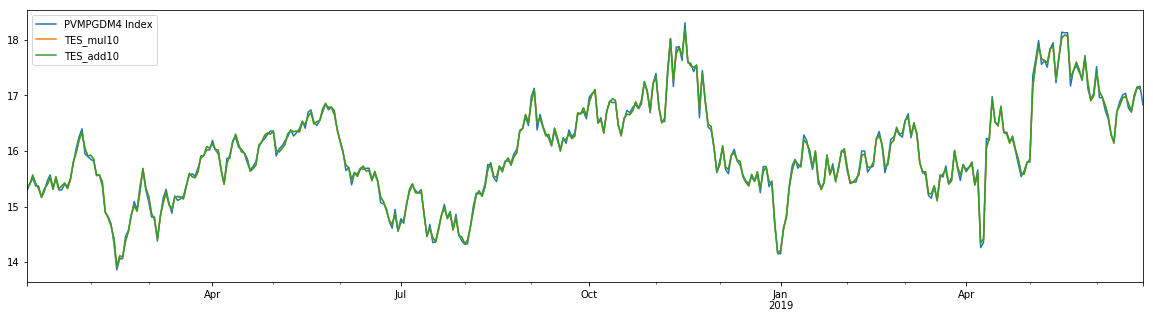

In [28]:
df1[[price_index,'TES_mul10','TES_add10']].plot(figsize=(20,5)).autoscale(axis='x',tight=True)

TES_add10 and TES_mul10 also show excellent performance, however we need to evaluate the model later to determine which one is the best.

In [33]:
df1.head()

,PVMPGDM4 Index,SMA_5,SMA_10,EMW_10,SES10,DES_add10,DES_mul10,TES_add10,TES_mul10
2018-01-02,15.28,NaN,NaN,15.280000,15.280000,15.285453,15.281753,15.345930,15.340764
2018-01-03,15.41,NaN,NaN,15.303636,15.303636,15.401479,15.398658,15.402038,15.400617
2018-01-04,15.51,NaN,NaN,15.341157,15.341157,15.503100,15.500375,15.568177,15.563024
2018-01-05,15.37,NaN,NaN,15.346401,15.346401,15.387547,15.384758,15.417697,15.413065
2018-01-08,15.37,15.388,NaN,15.350692,15.350692,15.375855,15.373088,15.324748,15.323107


### Evaluate DES and TES

In [42]:
from sklearn.metrics import mean_squared_error

labels = ['DES_add10','DES_mul10','TES_add10','TES_mul10']

for i in range(4):
    error = mean_squared_error(df1[price_index], df1[i])
    print(f'{labels[i]} Error: {error:11.10}')

KeyError: 0

In [50]:
error = np.sqrt(mean_squared_error(df1[price_index].iloc[1:], df1['DES_add10'].dropna()))
print('DES_add10 error : ', error)
error = np.sqrt(mean_squared_error(df1[price_index].iloc[1:], df1['DES_mul10'].dropna()))
print('DES_mul10 error : ', error)
error = np.sqrt(mean_squared_error(df1[price_index].iloc[1:], df1['TES_add10'].dropna()))
print('TES_add10 error : ', error)
error = np.sqrt(mean_squared_error(df1[price_index].iloc[1:], df1['TES_mul10'].dropna()))
print('TES_mul10 error : ', error)

DES_add10 error :  0.31233460513326033
DES_mul10 error :  0.31236364668930544
TES_add10 error :  0.30894426071788844
TES_mul10 error :  0.30895518483717055


In conclusion the model that is **addictive** show better performance and the best performing model is **TES_add10**

## Forecasting with the Holt-Winters Method

In [54]:
386-130

256

In [55]:
train_data = df1.iloc[:256]
test_data = df1.iloc[256:]

In [56]:
fitted_model_add = ExponentialSmoothing(train_data[price_index].astype(np.float),trend='add',seasonal='add',seasonal_periods=10).fit()

In [72]:
test_predictions_add = fitted_model_add.forecast(118).rename('HW Forecast add')

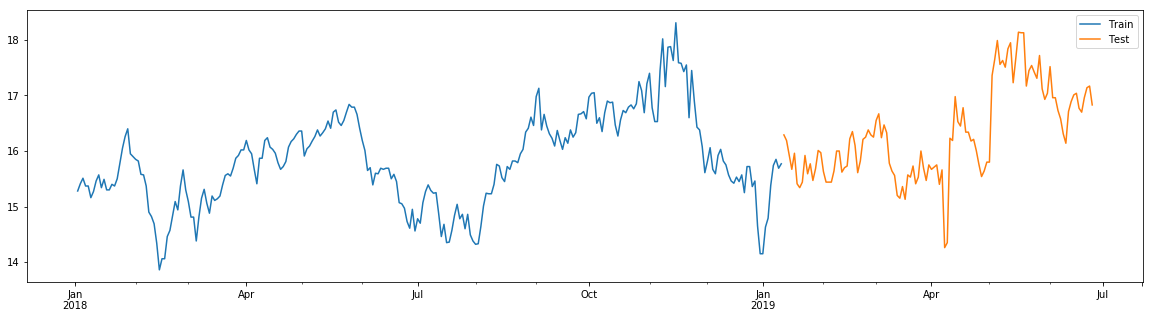

In [73]:
train_data[price_index].plot(legend=True,label='Train')
test_data[price_index].plot(legend=True,label='Test',figsize=(20,5));

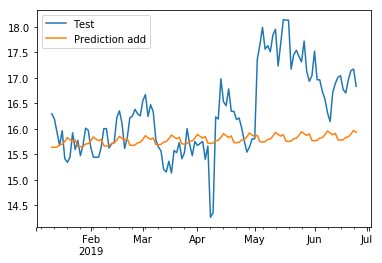

In [74]:
test_data[price_index].plot(legend=True,label='Test');
test_predictions_add.plot(legend=True,label='Prediction add')

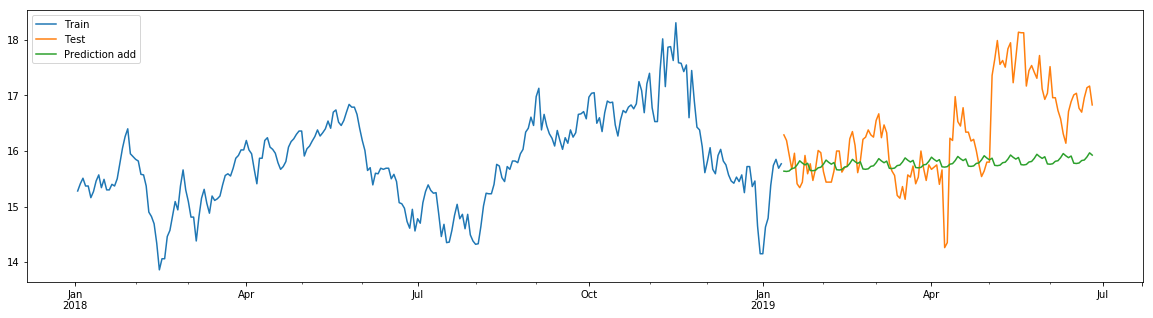

In [75]:
train_data[price_index].plot(legend=True,label='Train',figsize=(20,5))
test_data[price_index].plot(legend=True,label='Test');
test_predictions_add.plot(legend=True,label='Prediction add')

In [77]:
error = np.sqrt(mean_squared_error(test_predictions_add,test_data[price_index]))
print('HW error:', error)

HW error: 0.9475401319728545
